In this notebook, we tried to bactest 5 assets for 1 year from SnP500 using `zipline`.<br>
We've used `MACD` as a trend following indicator and `RSI` and `Bpllinger Bands` as mean-reversion indicator.<br>
Checked the performance interpretation of the strategy with the benchmark `SPY` using `quantstat`.<br>

### Import necessary libraries and modules

In [1]:
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders,order_target_percent,set_benchmark
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
from zipline.data import bundles
%matplotlib inline
import matplotlib.pyplot as plt
import quantstats as qs
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.tears import create_full_tear_sheet

In [ ]:
!zipline bundles;

csvdir <no ingestions>
quandl 2023-11-29 14:09:18.799451
quandl 2023-11-29 14:07:32.423012
quandl 2023-11-29 12:39:15.374615
quandl 2023-11-29 12:05:56.774662
quandl 2023-11-29 10:27:35.030664
quantopian-quandl 2023-11-30 02:02:00.355768
quantopian-quandl 2023-11-30 01:12:56.278980
quantopian-quandl 2023-11-30 01:11:49.450274
quantopian-quandl 2023-11-29 14:06:08.862893
quantopian-quandl 2023-11-29 13:55:59.391084
quantopian-quandl 2023-11-29 12:17:04.159981
quantopian-quandl 2023-11-29 10:27:07.529834
quantopian-quandl 2023-11-29 10:14:48.887188
sp5 2023-12-30 13:26:42.327070


### Preprocess the SnP500 data for ingesting into zipline

In [ ]:
# input_path = '/home/yakub/Documents/Finance_Data/Data/S_P 500 returns/OHLCV'
# output_path = '/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily'
# file_list = []

# for file in os.listdir(input_path):
#     file_path = os.path.join(input_path, file)
#     data = pd.read_csv(file_path)
#     data = data.rename(columns={'date': 'timestamp'})
#     data.columns = data.columns.str.lower()
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data = data.set_index('timestamp')
#     data.to_csv(os.path.join(output_path, file),index=True,index_label='timestamp')

In [ ]:
dt = pd.read_csv('/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily/A.csv')

In [ ]:
if dt.index.name == 'timestamp':
    print('yes')
else:
    print('no')

no


## EMA

$$ EMA = multiplier*{(P_t - EMA_{t-1})} + EMA_{t-1} $$
$$ multiplier = \frac{2}{n+1} $$
$$ n = \text{number of days} $$
$$ P_t = \text{price at time t} $$
$$ ema = \text{exponential moving average} $$

In [2]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

# MACD as the Treand Following Indicator

$$ MACD = EMA_{12} - EMA_{26} $$
$$ EMA_{12} = \text{12 day exponential moving average} $$
$$ EMA_{26} = \text{26 day exponential moving average} $$
$$ MACD_{signal} = EMA_{9} $$
$$ EMA_{9} = \text{9 day exponential moving average} $$
$$ MACD_{histogram} = MACD - MACD_{signal} $$

In [ ]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     context.asset = symbol("AAPL")
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
    
#     buy_signal = False
#     sell_signal  =False
#     price_hist = data.history(context.asset,'price', bar_count=26, frequency='1d')
    
#     ema_26 = ema(26,price_hist)
#     ema_12 = ema(12,price_hist)
#     MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#     signal = ema(9,MACD)
    
#     open_orders = get_open_orders()
#     if context.asset not in open_orders:
#         if MACD[-1]>signal[-1] and MACD[-2] < signal[-2]:    # Bullish crossover
#             order(context.asset,1)
#             buy_signal = True
#         elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
#             order(context.asset,0)
#             sell_signal = True
    
#     record( amz_close = data.current(context.asset, "close"),
#             MACD = MACD[-1],
#             signal =signal[-1],
#             sell_signal = sell_signal,
#             buy_signal = buy_signal,
#             price_hist = price_hist
#             )

### Take 5 assets from the snp500

In [12]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    set_benchmark(symbol('ABC'))
    context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    
def handle_data(context, data):
    context.i += 1
    if context.i < 1: return
    for asset in context.assets:
        buy_signal = False
        sell_signal  =False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_12[j]-ema_26[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        open_orders = get_open_orders()
        if asset not in open_orders:
            if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and MACD[-1] > 0 and trend_up:    # Bullish crossover
                order_target_percent(asset,0.5)
                buy_signal = True
            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and MACD[-1] < 0:    # Bearish crossover
                order_target_percent(asset,-0.5)
                sell_signal = True
            # else:
            #     order_target_percent(asset, 0)
        
        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                sell_signal = sell_signal,
                buy_signal = buy_signal,
                long_term_mavg=long_term_mavg,
                price_hist = price_hist
                )
        


start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

#stop_loss

In [ ]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
#     for asset in context.assets:
#         buy_signal = False
#         sell_signal  =False
#         price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
#         long_term_mavg = data.history(asset, 'close', bar_count=200, frequency='1d').mean()
#         trend_up = price_hist[-1] > long_term_mavg
        
#         ema_26 = ema(26,price_hist)
#         ema_12 = ema(12,price_hist)
#         MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#         signal = ema(9,MACD)
#         stop_loss_percentage = 2.0  # Adjust as needed
#         current_price = data.current(asset, 'close')
#         stop_loss_price = current_price * (1 - stop_loss_percentage / 100.0)
        
#         open_orders = get_open_orders()
#         if asset not in open_orders:
#             if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and trend_up:    # Bullish crossover
#                 order_target_percent(asset,0.5)
#                 buy_signal = True
#             elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and current_price < stop_loss_price:    # Bearish crossover
#                 order_target_percent(asset,-0.5)
#                 sell_signal = True
        
#         record( closing_price = data.current(asset, "close"),
#                 MACD = MACD[-1],
#                 signal =signal[-1],
#                 sell_signal = sell_signal,
#                 buy_signal = buy_signal,
#                 price_hist = price_hist,
#                 stop_loss_price=stop_loss_price
#                 )

In [13]:
result.tail(5)

,period_open,period_close,long_value,ending_cash,long_exposure,short_exposure,transactions,gross_leverage,net_leverage,starting_value,...,sharpe,sortino,max_leverage,algorithm_period_return,period_label,treasury_period_return,trading_days,alpha,beta,max_drawdown
2019-12-24 18:00:00+00:00,2019-12-24 14:31:00+00:00,2019-12-24 18:00:00+00:00,38521.441,-21498.376581,38521.441,0.0,[],2.262897,2.262897,38438.638,...,1.563844,2.241011,2.632035,0.702306,2019-12,0.0,248,0.739119,0.370981,-0.287615
2019-12-26 21:00:00+00:00,2019-12-26 14:31:00+00:00,2019-12-26 21:00:00+00:00,39284.037,-21498.376581,39284.037,0.0,[],2.208748,2.208748,38521.441,...,1.665675,2.400707,2.632035,0.778566,2019-12,0.0,249,0.819449,0.367977,-0.287615
2019-12-27 21:00:00+00:00,2019-12-27 14:31:00+00:00,2019-12-27 21:00:00+00:00,39245.788,-21498.376581,39245.788,0.0,[],2.211353,2.211353,39284.037,...,1.656775,2.387961,2.632035,0.774741,2019-12,0.0,250,0.812248,0.368101,-0.287615
2019-12-30 21:00:00+00:00,2019-12-30 14:31:00+00:00,2019-12-30 21:00:00+00:00,38701.547,-21498.376581,38701.547,0.0,[],2.249675,2.249675,39245.788,...,1.570267,2.257205,2.632035,0.720317,2019-12,0.0,251,0.761395,0.373884,-0.287615
2019-12-31 21:00:00+00:00,2019-12-31 14:31:00+00:00,2019-12-31 21:00:00+00:00,38835.801,-21498.376581,38835.801,0.0,[],2.239998,2.239998,38701.547,...,1.586676,2.280979,2.632035,0.733742,2019-12,0.0,252,0.760356,0.373754,-0.287615


## Funtions for MACD Plotting

In [14]:
def plot_macd(result, buy_signal=None, sell_signal=None):
    fig2, ax2 = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 4, 2]})


    # Closing price, signals, and long MA
    result["closing_price"].plot(ax=ax2[0], color='green', title="Closing Price")
    result["long_term_mavg"].plot(ax=ax2[0], color='purple', label="100-period MA")  # Added long MA
    result.loc[result["buy_signal"], "closing_price"].plot(ax=ax2[0], color='black', ls='None', marker='v', label="Long (buy)")
    result.loc[result["sell_signal"], "closing_price"].plot(ax=ax2[0], color='red', ls='None', marker='^', label="Sell (short)")
    ax2[0].legend()
    print(f'Buy signals: {result["buy_signal"].sum()}')
    print(f'Sell signals: {result["sell_signal"].sum()}')
    # MACD and signal line
    result["MACD"].plot(ax=ax2[1], color='blue', label="MACD")
    result["signal"].plot(ax=ax2[1], color='orange', label="Signal")
    ax2[1].legend()

    # Portfolio value
    result["portfolio_value"].plot(ax=ax2[2], color="blue", label="Portfolio Value")
    ax2[2].legend()
    plt.show()


Buy signals: 5
Sell signals: 2


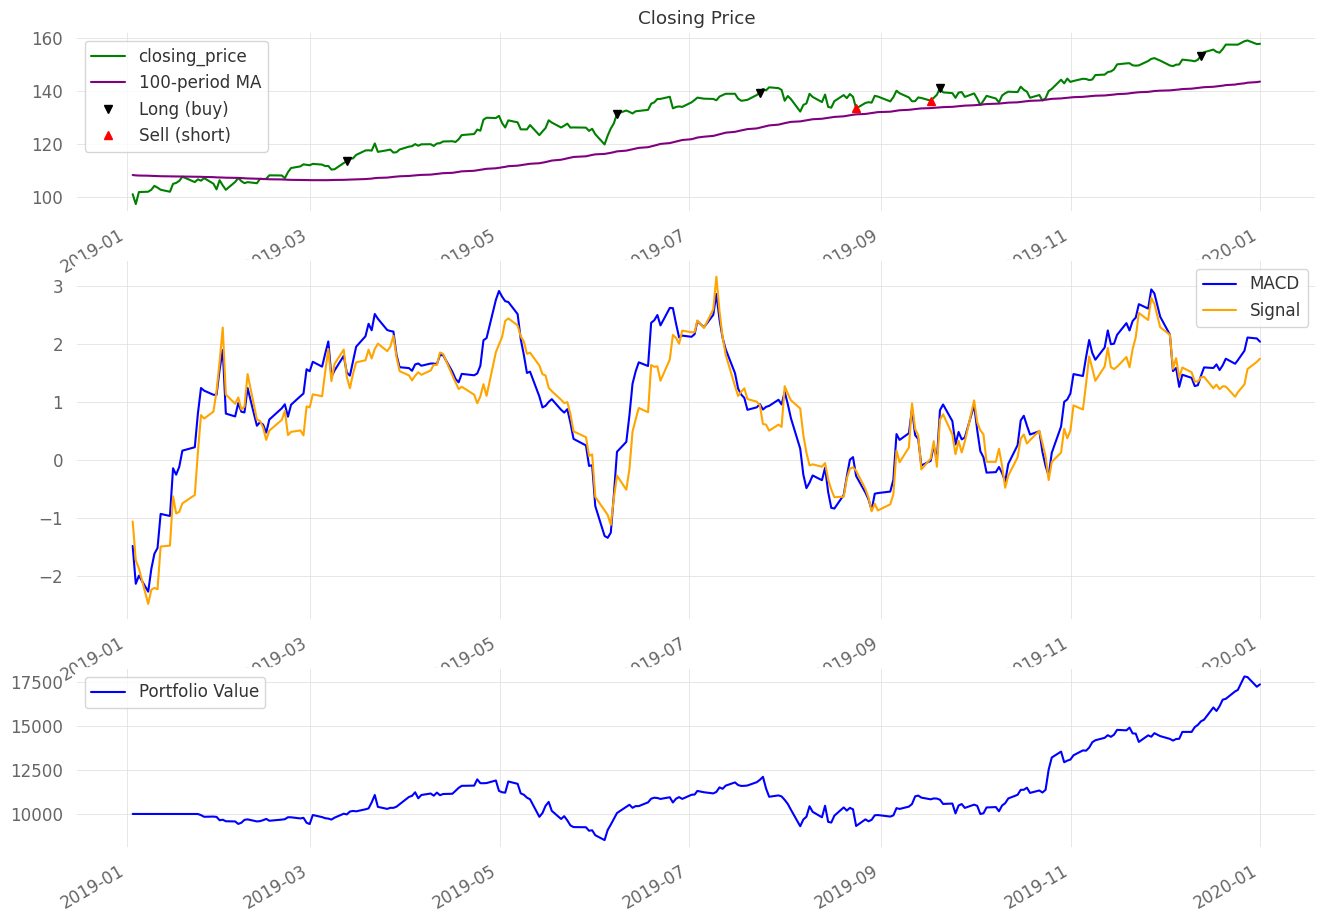

In [15]:
plot_macd(result)

## Benchmark 'SPY' for MACD Performance

Read the data of SnP500 index

In [16]:
spy = pd.read_csv("custom_data/d1/spy.csv")
spy.timestamp = pd.to_datetime(spy.timestamp)
spy.set_index('timestamp',inplace=True)
spy_return_series = spy['close'].pct_change()

In [17]:
spy_return_series = spy_return_series['2019-01-01':'2020-01-01']
spy_return_series


timestamp
2019-01-02    0.001040
2019-01-03   -0.023863
2019-01-04    0.033496
2019-01-07    0.007885
2019-01-08    0.009395
                ...   
2019-12-24    0.000031
2019-12-26    0.005323
2019-12-27   -0.000248
2019-12-30   -0.005513
2019-12-31    0.002429
Name: close, Length: 252, dtype: float64

In [ ]:
# spy_return_series.index = spy_return_series.index.tz_localize(None)

In [18]:
returns = result.returns
returns

2019-01-02 21:00:00+00:00    0.000000
2019-01-03 21:00:00+00:00    0.000000
2019-01-04 21:00:00+00:00    0.000000
2019-01-07 21:00:00+00:00    0.000000
2019-01-08 21:00:00+00:00    0.000000
                               ...   
2019-12-24 18:00:00+00:00    0.004888
2019-12-26 21:00:00+00:00    0.044798
2019-12-27 21:00:00+00:00   -0.002151
2019-12-30 21:00:00+00:00   -0.030666
2019-12-31 21:00:00+00:00    0.007804
Name: returns, Length: 252, dtype: float64

Convert the timezone to none to avoid the warning while comparing with the benchmark

In [19]:
returns.index = returns.index.tz_localize(None)
returns

2019-01-02 21:00:00    0.000000
2019-01-03 21:00:00    0.000000
2019-01-04 21:00:00    0.000000
2019-01-07 21:00:00    0.000000
2019-01-08 21:00:00    0.000000
                         ...   
2019-12-24 18:00:00    0.004888
2019-12-26 21:00:00    0.044798
2019-12-27 21:00:00   -0.002151
2019-12-30 21:00:00   -0.030666
2019-12-31 21:00:00    0.007804
Name: returns, Length: 252, dtype: float64

In [ ]:
# spy_return_series.index = spy_return_series.index.tz_localize('UTC')
# spy_return_series = spy_return_series.tz_convert('UTC')

In [ ]:
# print(returns.index.tz)
# print(spy_return_series.index.tz)

### Quantstat Tearsheet for Macd 

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-01-23   2019-01-23
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             29.0%        100.0%

Cumulative Return          22.19%       73.37%
CAGR﹪                     15.91%       50.0%

Sharpe                     1.9          1.63
Prob. Sharpe Ratio         100.0%       93.84%
Smart Sharpe               1.89         1.63
Sortino                    8.64         2.35
Smart Sortino              8.63         2.34
Sortino/√2                 6.11         1.66
Smart Sortino/√2           6.1          1.66
Omega                      1.34         1.34

Max Drawdown               -2.13%       -28.76%
Longest DD Days            245          91
Volatility (ann.)          11.53%       40.85%
R^2                        0.0          0.0
Information Ratio          0.07         0.07
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-04-24,2019-06-03,2019-07-23,91,-28.761504,-26.455039
2,2019-07-25,2019-08-05,2019-10-23,91,-23.118811,-23.005934
3,2019-03-22,2019-03-25,2019-04-02,12,-7.098685,-6.573303
4,2019-01-24,2019-02-28,2019-03-08,44,-5.676262,-5.626489
5,2019-11-20,2019-11-22,2019-12-09,20,-5.466623,-4.943018


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


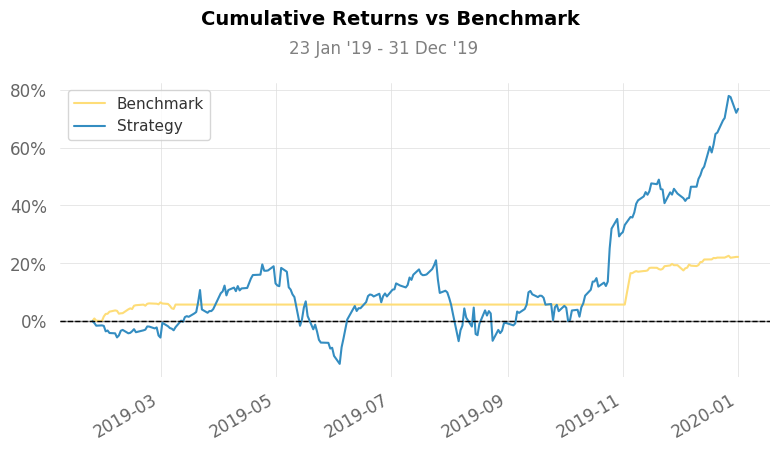

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


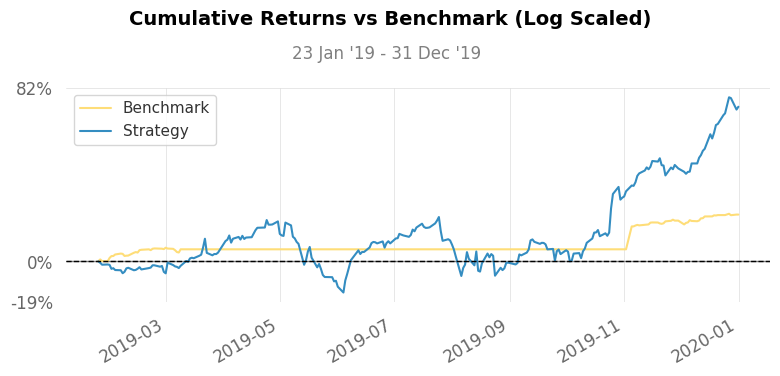

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


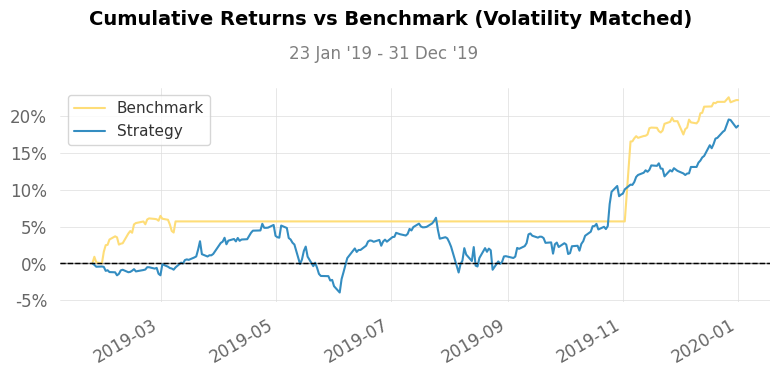

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


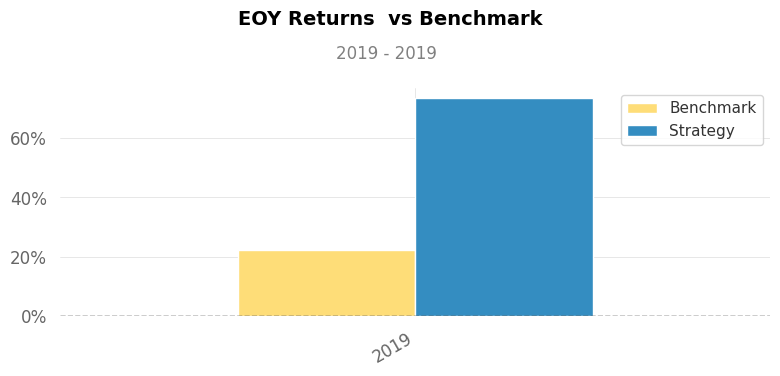

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


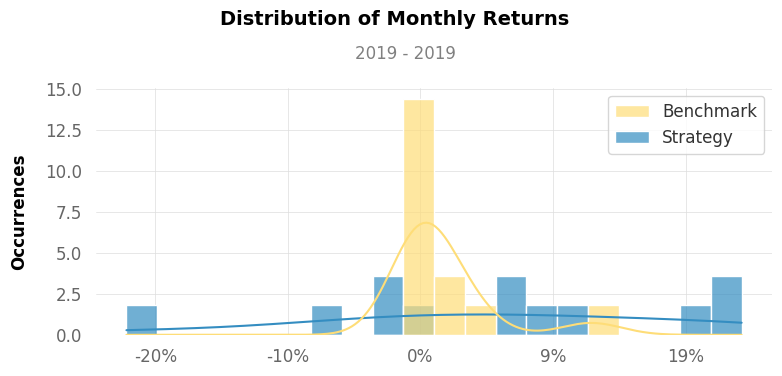

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


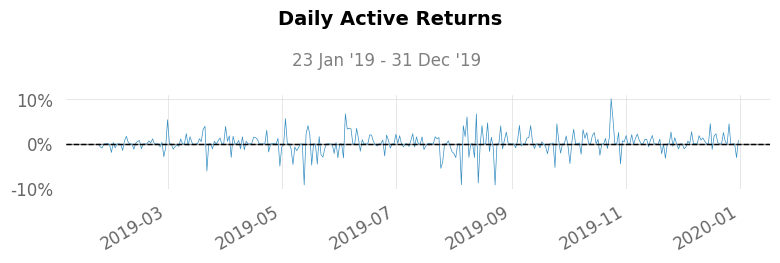

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


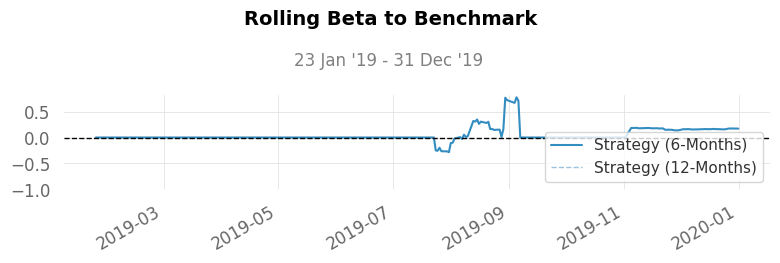

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


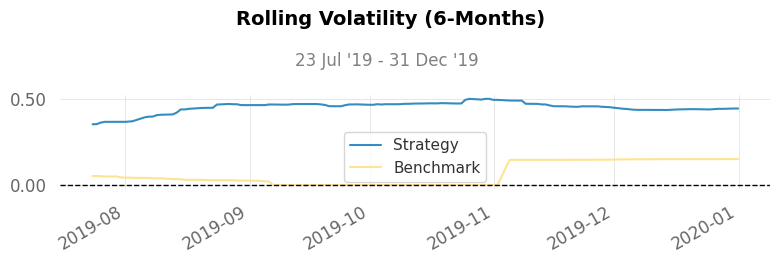

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


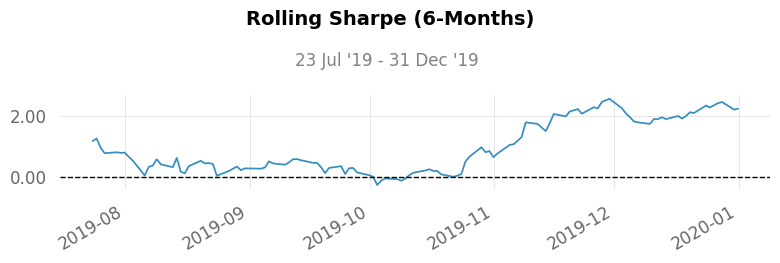

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


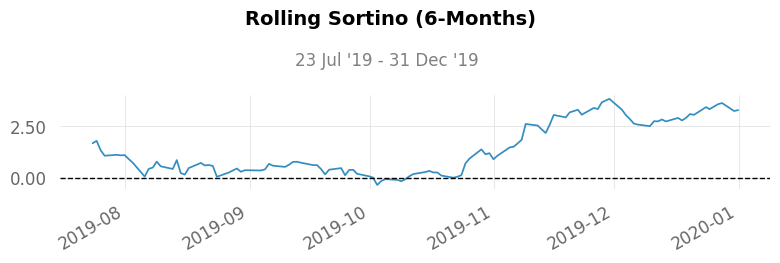

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


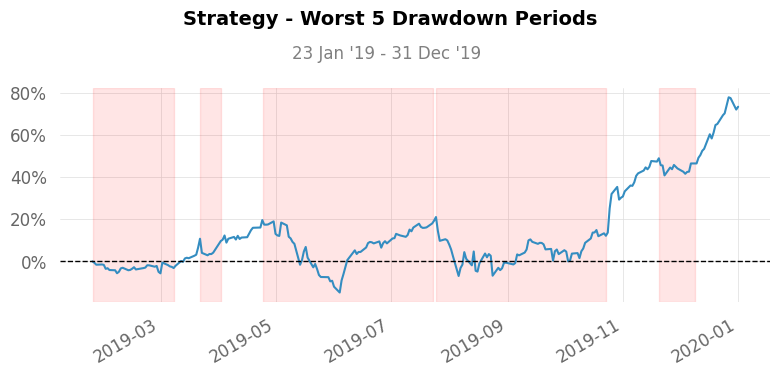

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


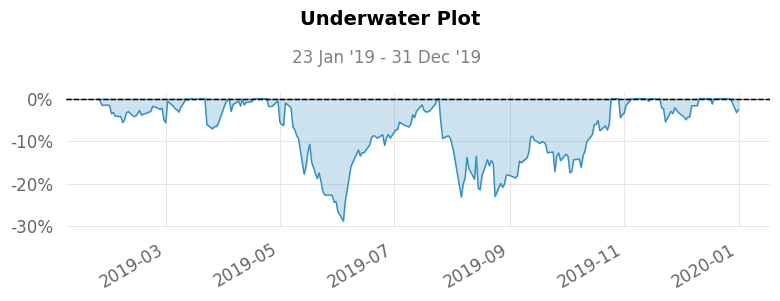

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


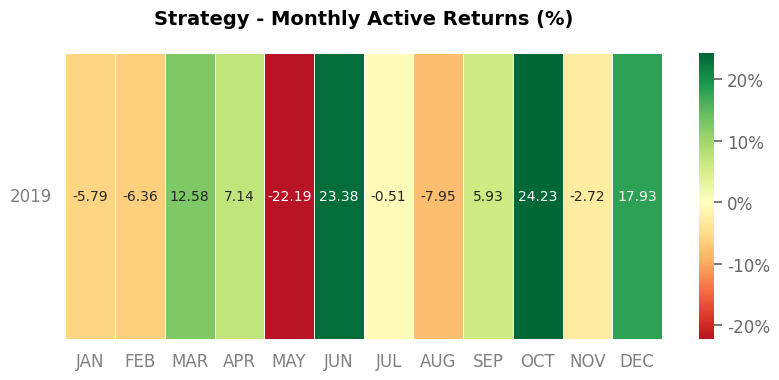

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


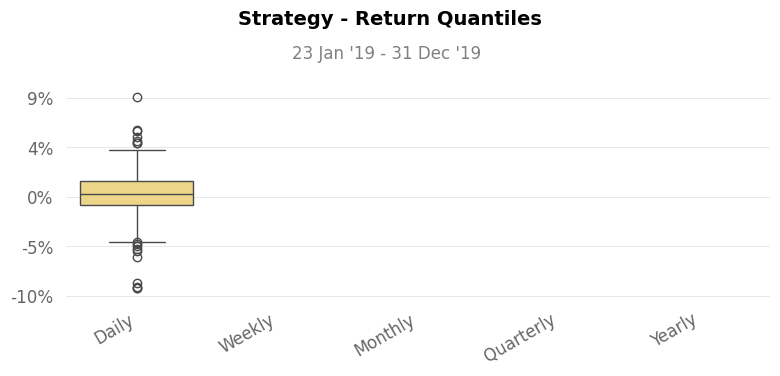

In [20]:
qs.reports.full(returns,benchmark=spy_return_series)

### Interpretation

The strategy with MACD indicator performs comparativly better than the benchmark.<br>

**Cumulative Return**          
* Benchmark: 22.19%        
* Strategy : 73.37%<br>

**Sharp Ratio**<br>

* Benchmark: 1.9 
* Strategy: 1.63<br>

Our strategy achieved a higher cumulative return 73.37% and its Sharpe Ratio is lower than the benchmark.<br>This suggests that the strategy generated returns at the cost of significantly higher risk or volatility, it is more risky compared to benchmark 'SPY'.

### Pyfolio Tear Sheet for Macd

In [ ]:
# returns_m, positions_m, transactions_m = extract_rets_pos_txn_from_zipline(result)
# create_full_tear_sheet(returns_m, positions=positions_m, transactions=transactions_m)

# RSI as Mean Reversion Indicator

In [ ]:
bundle = 'sp5'
bundle_data = bundles.load(bundle)

In [ ]:
sids = bundle_data.asset_finder.sids
len(sids)

501

In [ ]:
ast = bundle_data.asset_finder.retrieve_all(sids)
ast[:5]

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV])]

In [ ]:
def RSI(df, window, matype=1):
    rsi_period = window

    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

    if matype==2:
        df['ema_gain'] = df['gain'].ewm(span=rsi_period, min_periods=rsi_period).mean()
        df['ema_loss'] = df['loss'].ewm(span=rsi_period, min_periods=rsi_period).mean()
    if matype==1:
        df['ema_gain'] = df['gain'].rolling(rsi_period).mean()
        df['ema_loss'] = df['loss'].rolling(rsi_period).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df

In [ ]:
bundle = 'sp5'
bundle_data = bundles.load(bundle)

In [ ]:
%%capture
capital_base = 10000
calendar = get_calendar('XNYS')
window = 30

def initialize(context):
    context.i = 0
    # context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]   # 5 assets from the bundle

def handle_data(context, data):
    context.i += 1
    if context.i < window+1:
        return
    for asset in context.assets:
        prices = data.history(asset, ['open','close','price'], bar_count=30, frequency='1d')
        rsi_value = RSI(prices, 14,matype=2).rsi_14[-1]
        
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, "price")
            #open_orders = get_open_orders()
            if rsi_value > 70:
                order_target_percent(asset, -10, stop_price=(price * 0.90))
            elif rsi_value < 30:
                order_target_percent(asset, 10, stop_price=(price * 0.90))
            else:
                order_target(asset, 0)

        record(closing_price=data.current(asset, 'close'),
            rsi=rsi_value)

#............................................................................................
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_rsi = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Funtions for RSI Plotting

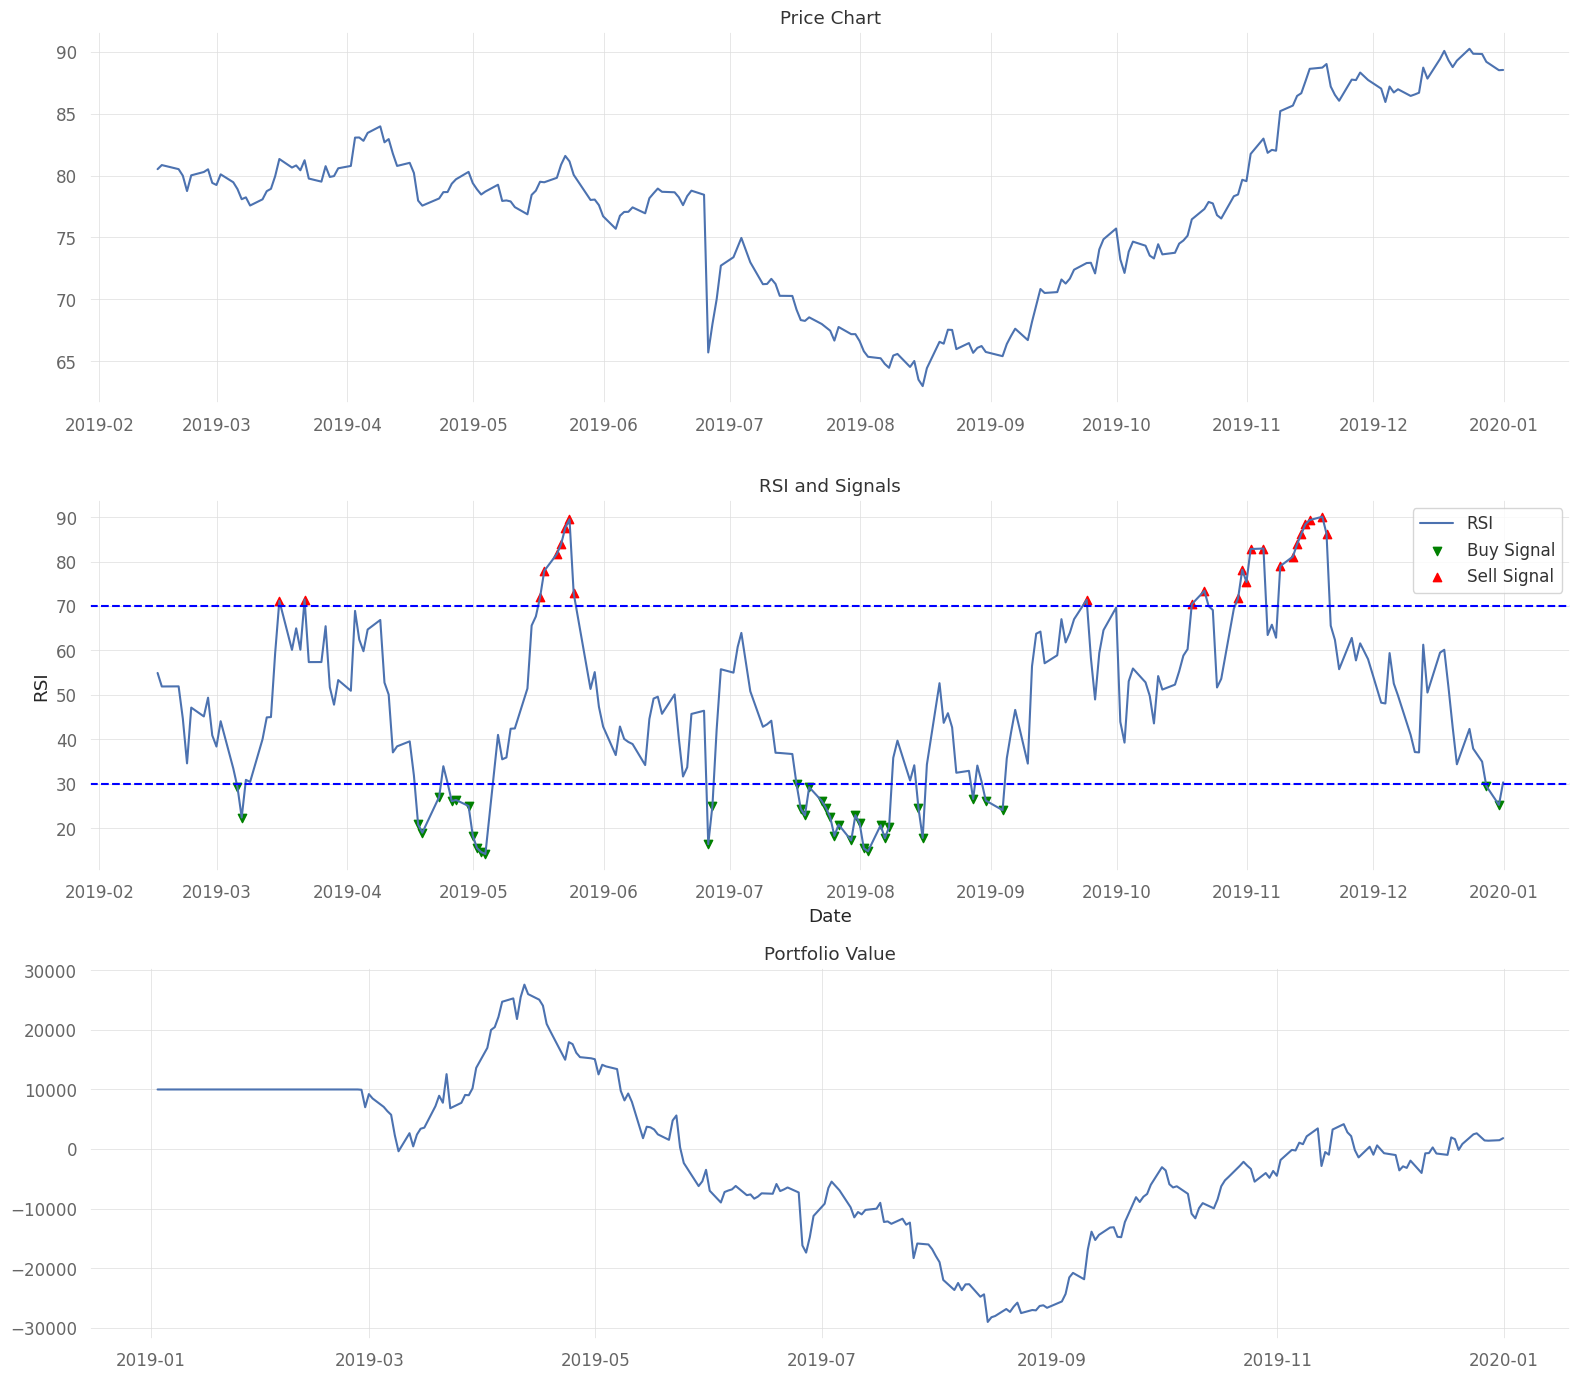

Buycount:38, Sellcount:25


In [ ]:

fig, (ax1, ax2,ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price Chart')

ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

print(f'Buycount:{len(buy_signals.index)}, Sellcount:{len(sell_signals.index)}')

# Performance plot
# (1 + result_rsi['portfolio_value'].pct_change()).cumprod().plot(ax=ax3)
# (1 + result_rsi['closing_price'].pct_change()).cumprod().plot(ax=ax3)
# ax3.set_ylabel('Performance')
# ax3.legend(['Portfolio', 'Asset'])

# plt.tight_layout()
# plt.show()

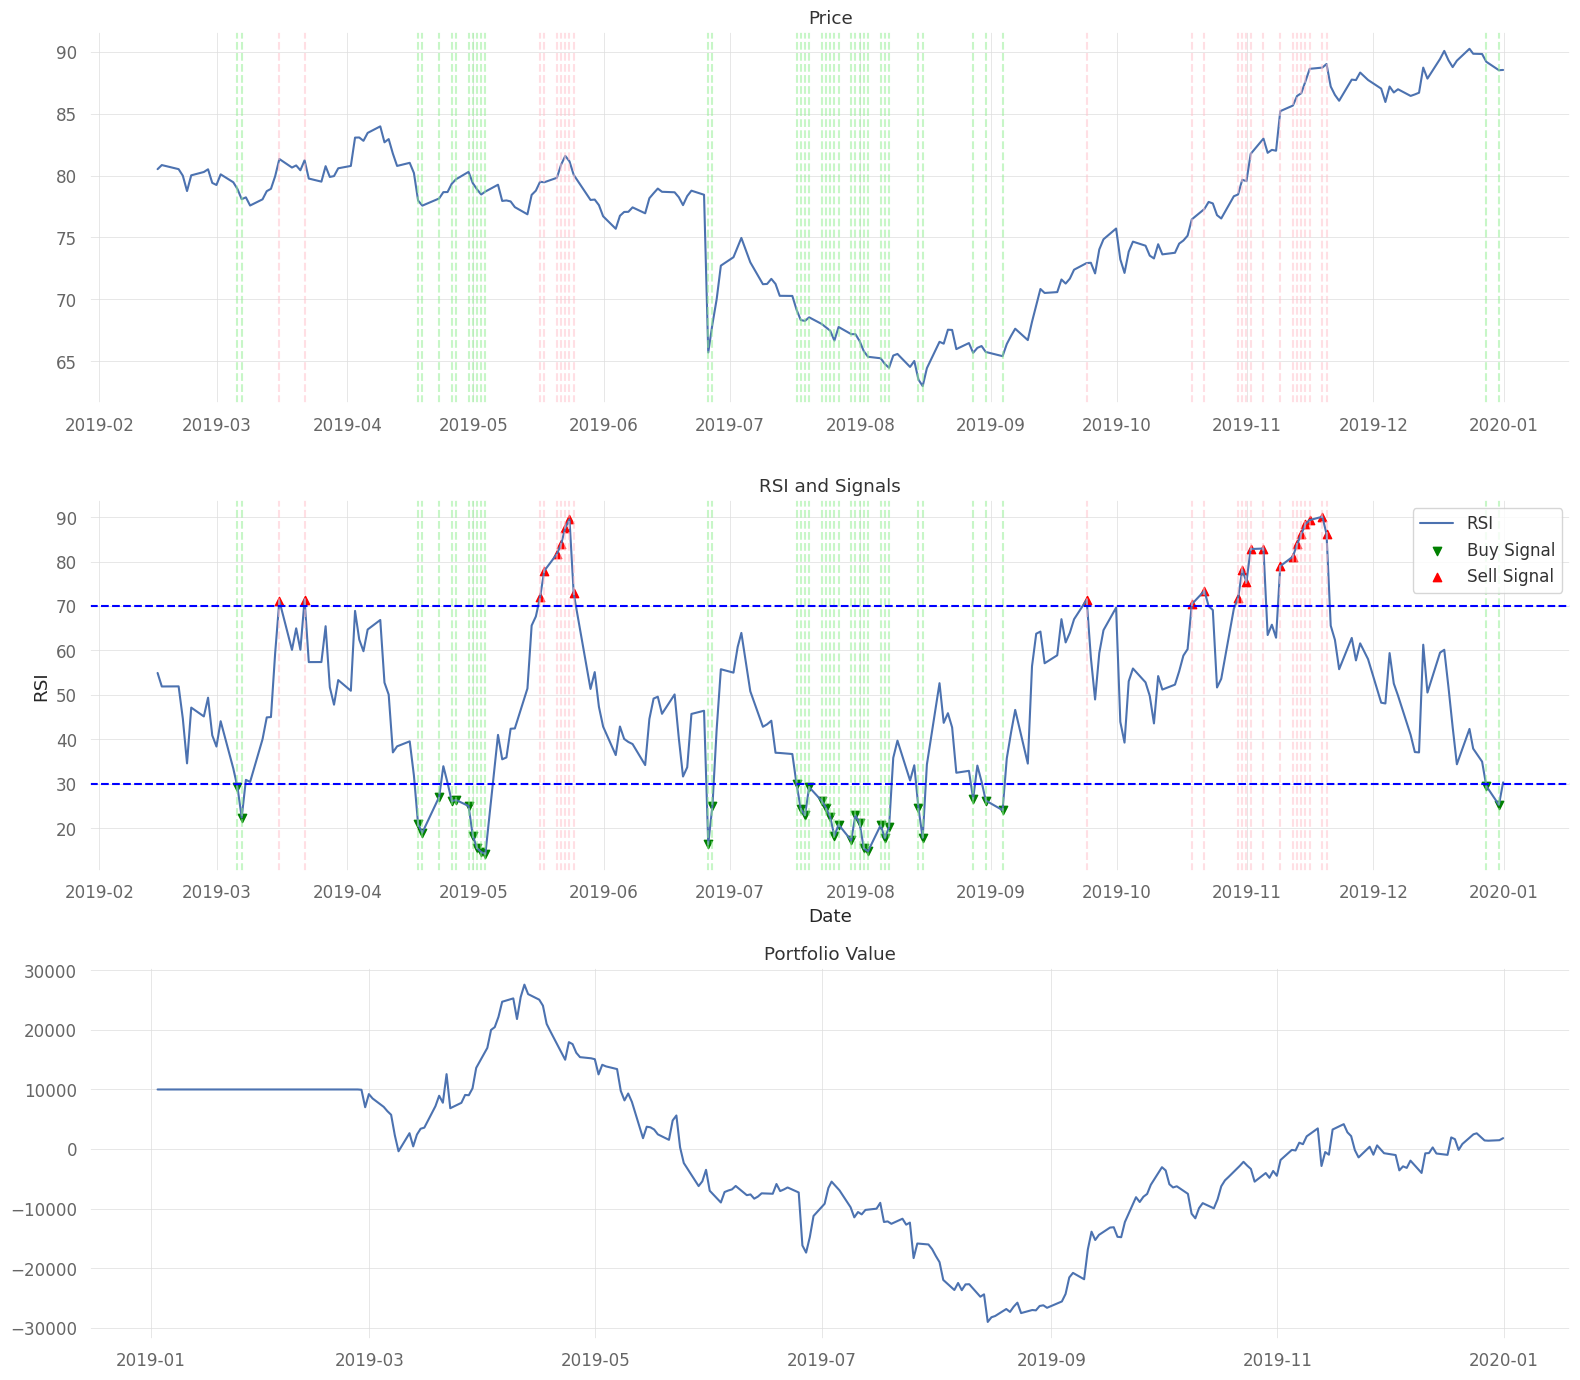

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price')

ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

for buy_date in buy_signals.index:
    ax1.axvline(x=buy_date, color='lightgreen', linestyle='--', alpha=0.5)
    ax2.axvline(x=buy_date, color='lightgreen', linestyle='--', alpha=0.5)

for sell_date in sell_signals.index:
    ax1.axvline(x=sell_date, color='pink', linestyle='--', alpha=0.5)
    ax2.axvline(x=sell_date, color='pink', linestyle='--', alpha=0.5)

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

## Benchmark 'SPY' for RSI Performance

Convert the timezone to none to avoid the warning while comparing with the benchmark

In [ ]:
returns_rsi = result_rsi.returns
returns_rsi.index = returns_rsi.index.tz_localize(None)

### Quantstat Tearsheet for RSI 

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-02-26   2019-02-26
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             22.0%        100.0%

Cumulative Return          15.23%       -81.71%
CAGR﹪                     12.3%        -75.09%

Sharpe                     1.48         -1.82
Prob. Sharpe Ratio         99.86%       2.84%
Smart Sharpe               1.44         -1.77
Sortino                    7.65         -2.08
Smart Sortino              7.44         -2.02
Sortino/√2                 5.41         -1.47
Smart Sortino/√2           5.26         -1.43
Omega                      0.55         0.55

Max Drawdown               -2.13%       -205.15%
Longest DD Days            245          264
Volatility (ann.)          11.69%       2183.72%
R^2                        0.0          0.0
Information Ratio          -0.11        -0.11
Calmar   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-04-12,2019-08-14,2019-12-31,264,-205.152959,-201.546926
2,2019-02-27,2019-03-08,2019-03-20,21,-103.751185,-95.506080
3,2019-03-22,2019-03-22,2019-03-28,7,-45.495540,-38.285319
4,2019-04-09,2019-04-09,2019-04-09,1,-13.705007,NaN


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


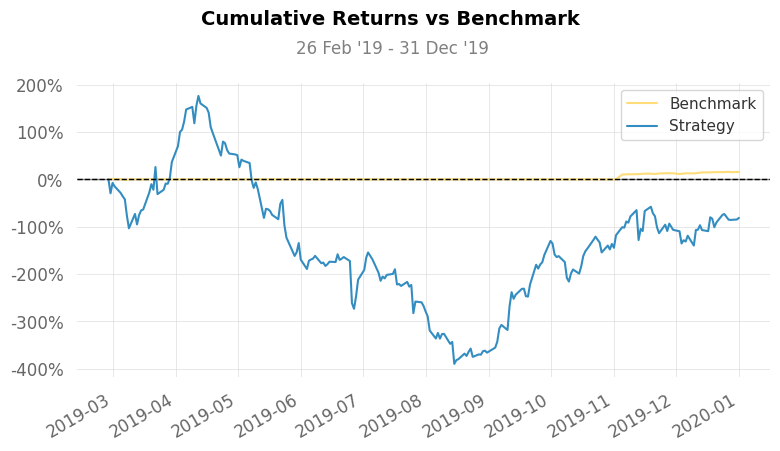

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


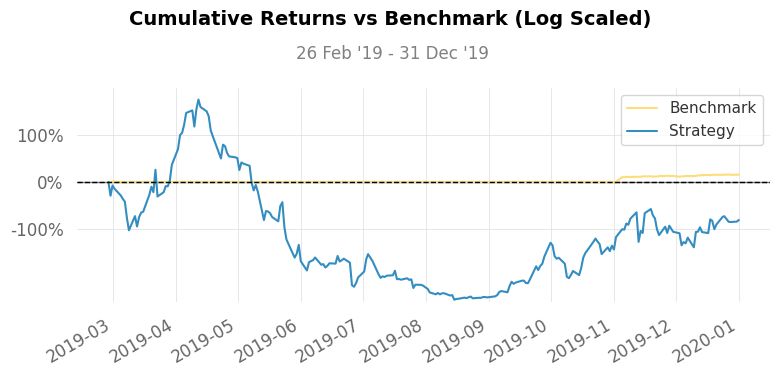

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


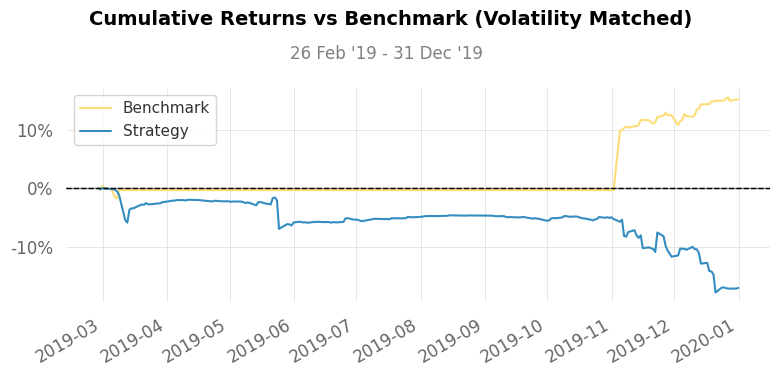

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


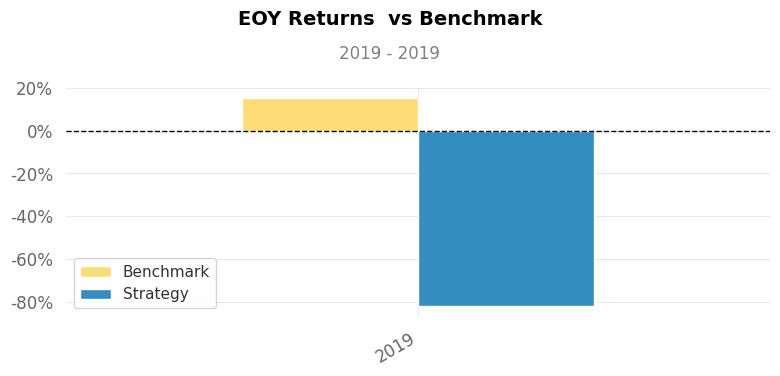

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


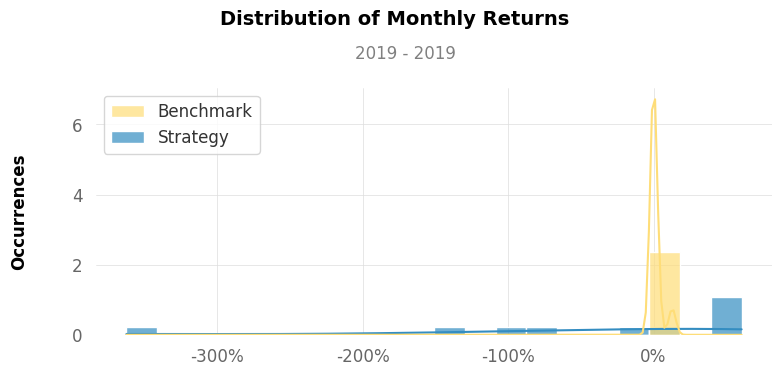

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


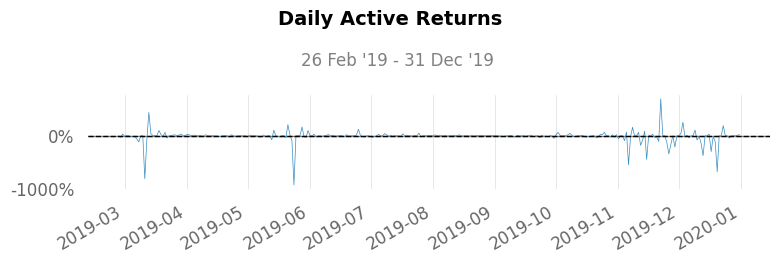

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


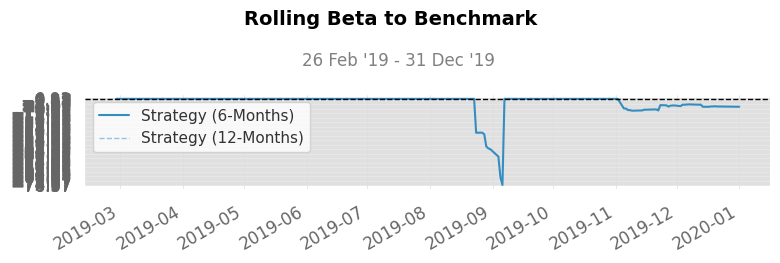

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


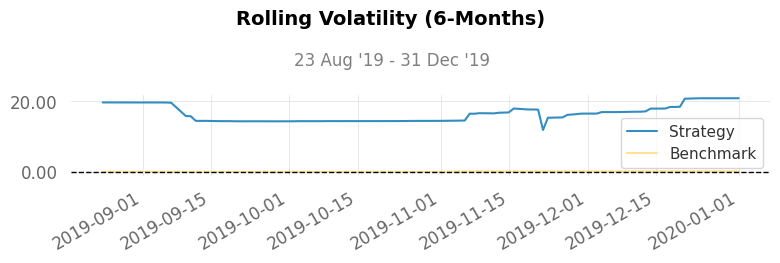

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


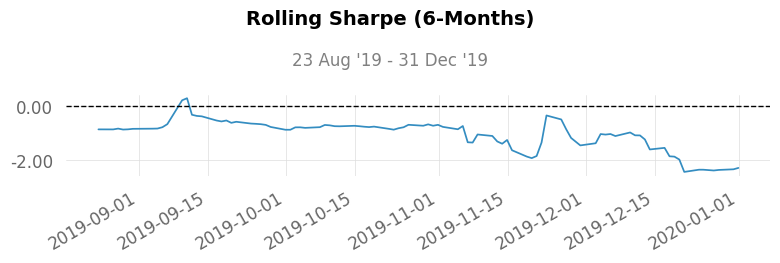

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


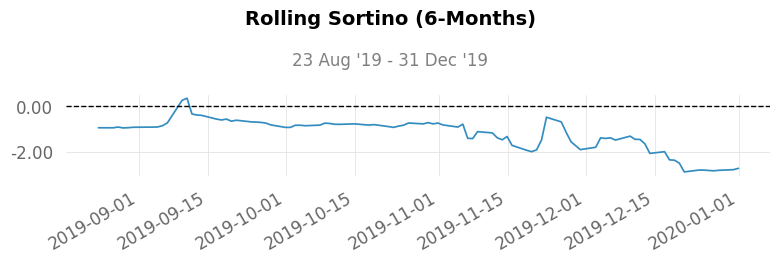

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


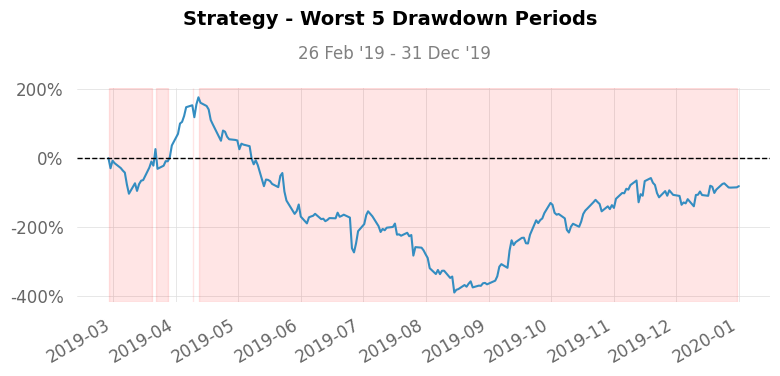

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


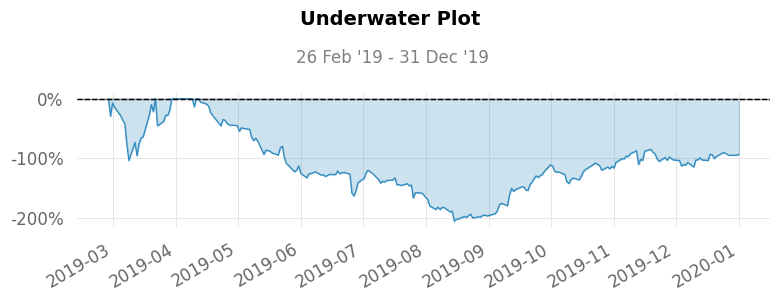

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


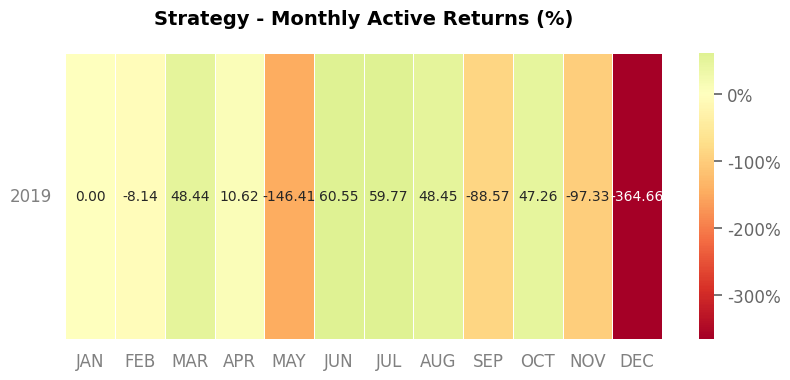

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


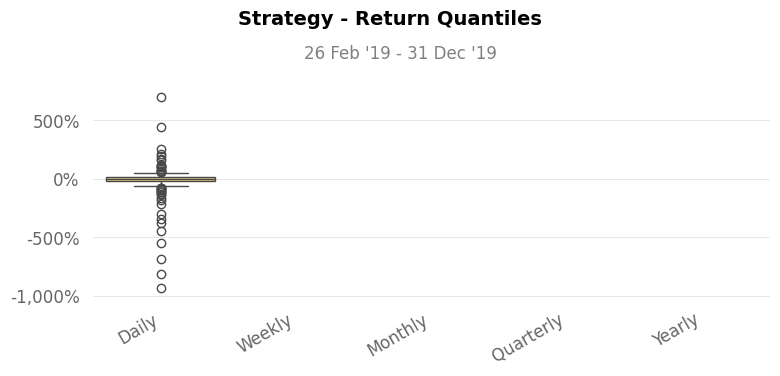

In [ ]:
qs.reports.full(returns_rsi,benchmark=spy_return_series)

# Bollinger Bands

In [ ]:
%%capture
capital_base = 10000
calendar = get_calendar('XNYS')
window = 30

def initialize(context):
    context.i = 0
    # set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]
    

def handle_data(context, data):
    # Skip first 90 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            current_price = data.current(asset, "price")
            prices = data.history(asset, 'close', 31, frequency='1d')
            sma = prices.mean()
            rolling_std = prices.std()
            upper_band = sma + (2 * rolling_std)
            lower_band = sma - (2 * rolling_std)

            if current_price > upper_band:
                order_target(asset, 0)      # selliing
            elif current_price < lower_band:
                order_target(asset, 100)   
            else:
                pass
            record(
            ASSET_price=data.current(asset, "price"),
            upper_band=upper_band,
            lower_band=lower_band
        )


    
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_bb = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

## Funtions for Bollinger Bands Plotting

Buy signals: 4
Sell signals: 21


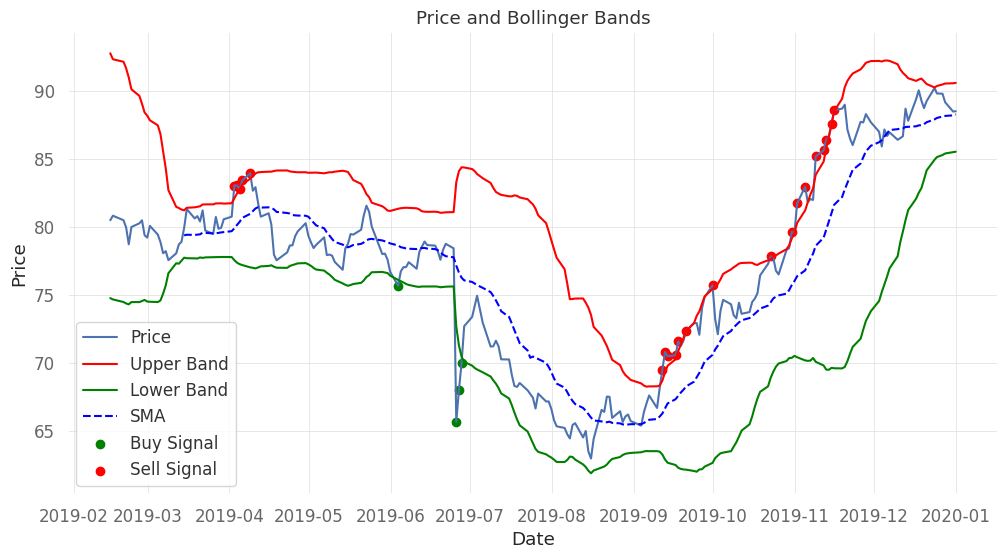

In [ ]:
result_bb['sma'] = result_bb['ASSET_price'].rolling(window=20).mean()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(result_bb.index, result_bb['ASSET_price'], label='Price')
ax.plot(result_bb.index, result_bb['upper_band'], label='Upper Band', color='red')
ax.plot(result_bb.index, result_bb['lower_band'], label='Lower Band', color='green')

ax.plot(result_bb.index, result_bb['sma'], label='SMA', color='blue',linestyle='--')

buy_signals = result_bb[result_bb['ASSET_price'] < result_bb['lower_band']]
sell_signals = result_bb[result_bb['ASSET_price'] > result_bb['upper_band']]
ax.scatter(buy_signals.index, buy_signals['ASSET_price'], color='green', label='Buy Signal')
ax.scatter(sell_signals.index, sell_signals['ASSET_price'], color='red', label='Sell Signal')

print(f'Buy signals: {len(buy_signals)}')
print(f'Sell signals: {len(sell_signals)}')

ax.set_title('Price and Bollinger Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.show()


In [ ]:
returns_bb = result_bb.returns
returns_bb.index = returns_bb.index.tz_localize(None)

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-03-08   2019-03-08
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             19.0%        87.0%

Cumulative Return          17.27%       33.44%
CAGR﹪                     14.42%       27.63%

Sharpe                     1.7          0.98
Prob. Sharpe Ratio         100.0%       80.47%
Smart Sharpe               1.65         0.95
Sortino                    10.41        1.34
Smart Sortino              10.09        1.3
Sortino/√2                 7.36         0.95
Smart Sortino/√2           7.14         0.92
Omega                      1.24         1.24

Max Drawdown               -1.88%       -28.65%
Longest DD Days            14           126
Volatility (ann.)          11.81%       47.87%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-05-07,2019-06-03,2019-09-09,126,-28.654439,-27.690447
2,2019-09-16,2019-10-03,2019-10-24,39,-3.765159,-3.684706
3,2019-12-09,2019-12-09,2019-12-09,1,-2.384606,NaN
4,2019-12-11,2019-12-16,2019-12-16,6,-2.062513,-0.741578
5,2019-03-15,2019-03-25,2019-03-29,15,-1.916109,-1.556839


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


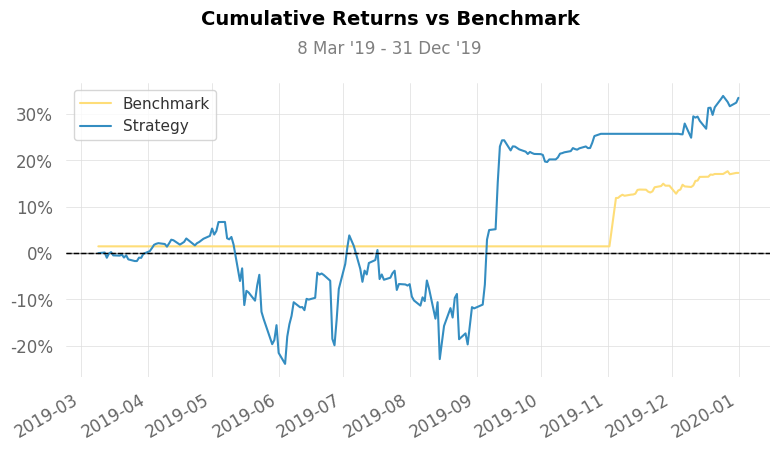

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


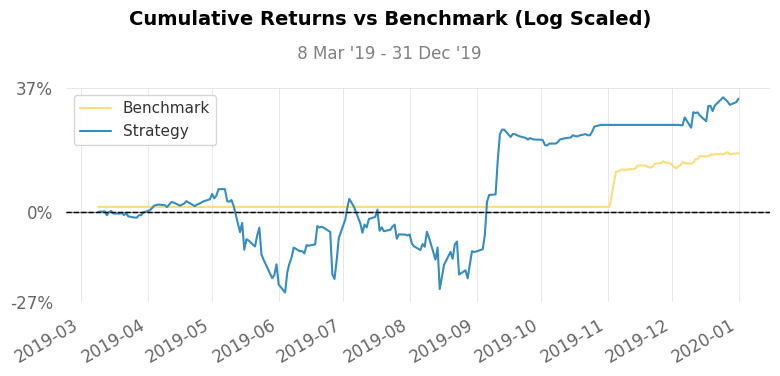

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


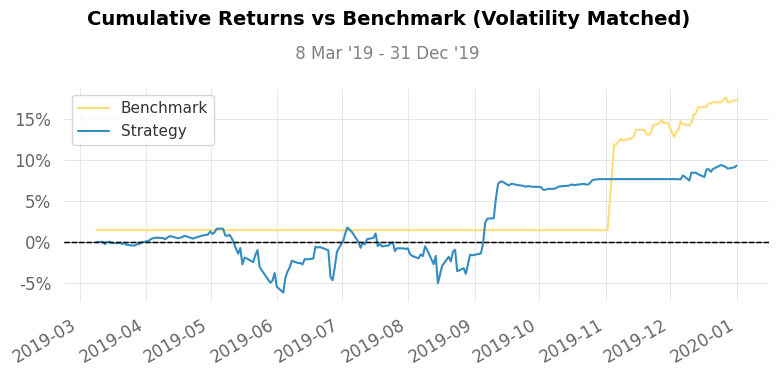

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


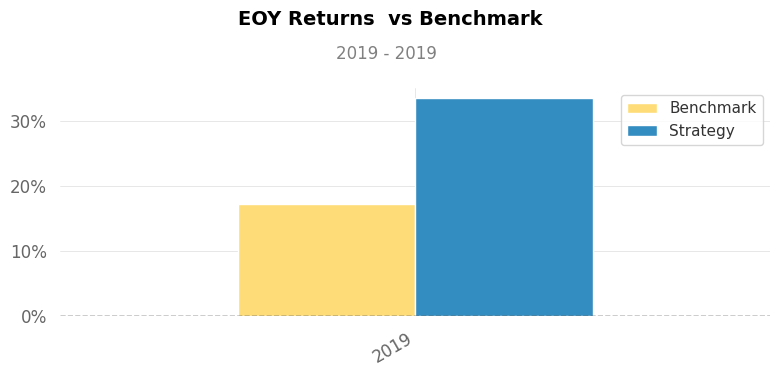

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


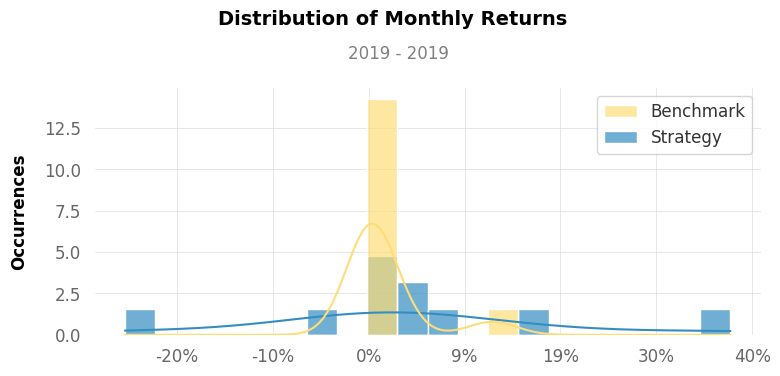

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


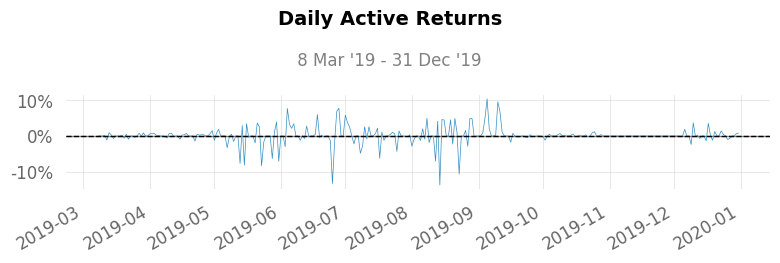

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


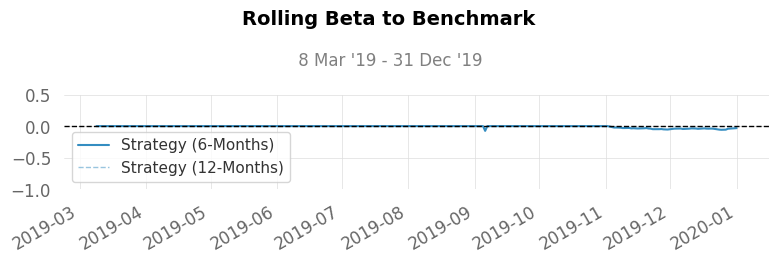

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


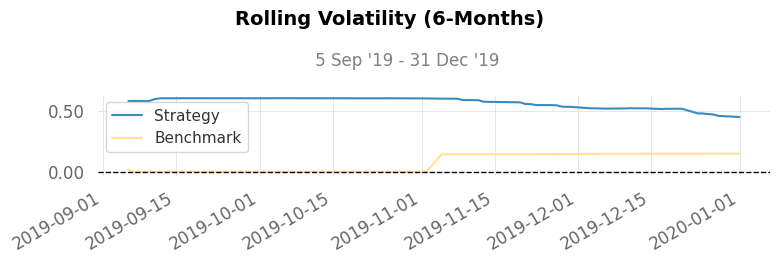

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


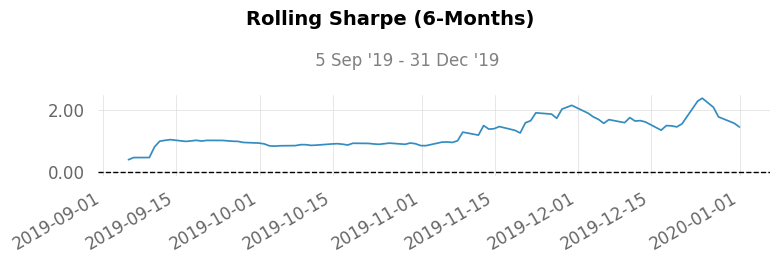

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


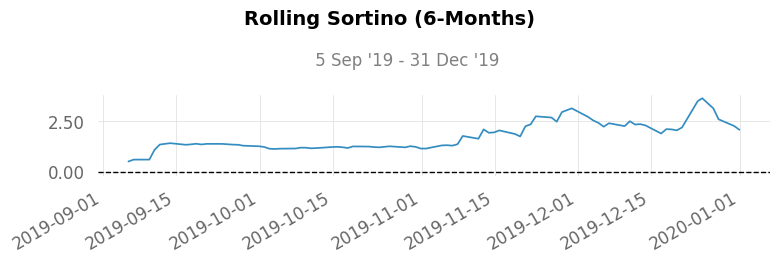

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


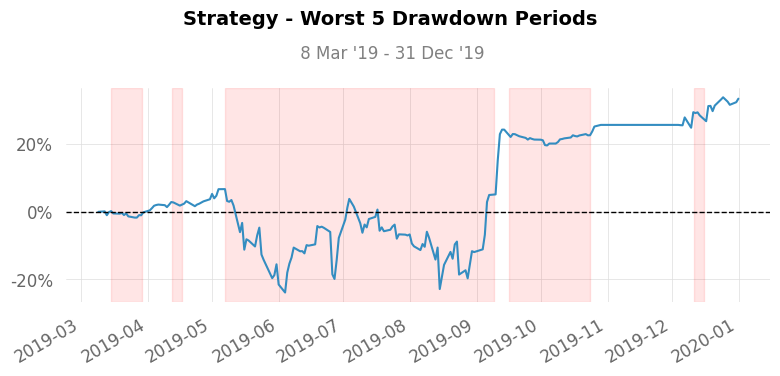

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


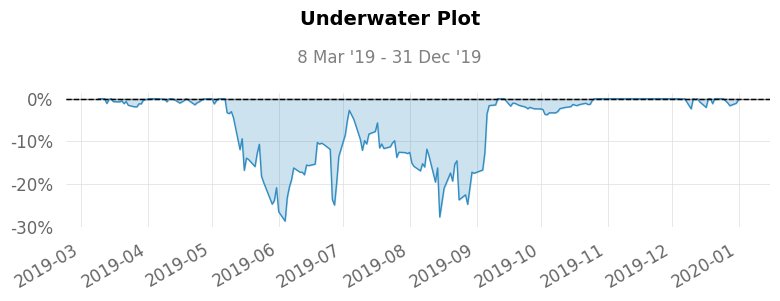

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


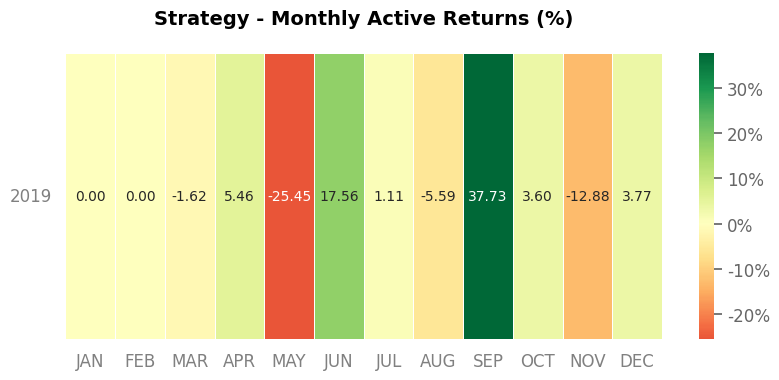

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


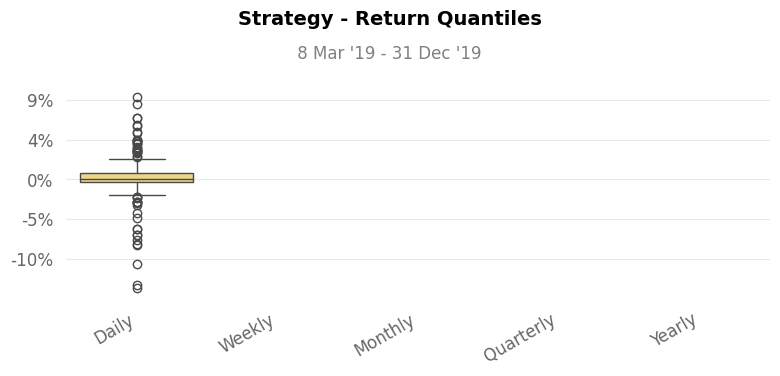

In [ ]:
qs.reports.full(returns_bb,benchmark=spy_return_series)

### Interpretation:

The strategy with bollinger bands indicator performs comparativly better than the benchmark.<br>

**Cumulative Return**          
* Benchmark: 17.27%       
* Strategy : 33.44%<br>

**Sharp Ratio**<br>

* Benchmark: 1.7
* Strategy: 0.98<br>

Our strategy achieved a higher cumulative return 33.44% but its Sharpe Ratio is lower than the benchmark.<br>This suggests that the strategy generated returns at the cost of significantly higher volatility, it is more risky compared to benchmark 'SPY'.

# RSI + Bollinger Bands

In [ ]:
%%capture
capital_base = 10000
calendar = get_calendar('XNYS')
window = 30

def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]

def handle_data(context, data):
    context.i += 1
    if context.i < window + 1:
        return

    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            prices = data.history(asset, ['open', 'close', 'price'], bar_count=30, frequency='1d')
            rsi_value = RSI(prices, 14, matype=2).rsi_14[-1]

            current_price = data.current(asset, "price")
            prices_31 = data.history(asset, 'close', 31, frequency='1d')
            sma = prices_31.mean()
            rolling_std = prices_31.std()
            upper_band = sma + (2 * rolling_std)
            lower_band = sma - (2 * rolling_std)

            # rsi and bollinger bands
            if rsi_value > 70 and current_price > upper_band:  # Overbought and above upper Bollinger Band
                order_target_percent(asset, -10, stop_price=(current_price * 0.90))
            elif rsi_value < 30 and current_price < lower_band:  # Oversold and below lower Bollinger Band
                order_target_percent(asset, 10, stop_price=(current_price * 0.90))
            else:
                order_target(asset, 0)

            record(
                closing_price=data.current(asset, 'close'),
                rsi=rsi_value,
                upper_band=upper_band,
                lower_band=lower_band
            )

# ............................................................................................
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_rsi_bollinger = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

Convert the timezone to none to avoid the warning while comparing with the benchmark

In [ ]:
result_rsi_bollinger.returns.index = result_rsi_bollinger.returns.index.tz_localize(None)

## Benchmark 'SPY' for comparing RSI+Bollinger Performance

/home/yakub/anaconda3/envs/ml/lib/python3.10/site-packages/quantstats/utils.py:269: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/yakub/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axi

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2019-03-08   2019-03-08
End Period                 2019-12-31   2019-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             19.0%        68.0%

Cumulative Return          17.27%       -887.18%
CAGR﹪                     14.42%       472.47%

Sharpe                     1.7          0.89
Prob. Sharpe Ratio         100.0%       76.91%
Smart Sharpe               1.18         0.62
Sortino                    10.41        1.17
Smart Sortino              7.24         0.81
Sortino/√2                 7.36         0.83
Smart Sortino/√2           5.12         0.57
Omega                      1.31         1.31

Max Drawdown               -1.88%       -404.88%
Longest DD Days            14           239
Volatility (ann.)          11.81%       358.33%
R^2                        0.0          0.0
Information Ratio          0.05         0.05
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-05-07,2019-11-21,2019-12-31,239,-404.878042,-373.603231
2,2019-03-15,2019-03-25,2019-03-29,15,-57.707564,-46.887396
3,2019-03-12,2019-03-12,2019-03-13,2,-33.946870,-5.243312
4,2019-04-22,2019-04-22,2019-04-26,5,-22.089740,-14.104872
5,2019-04-12,2019-04-15,2019-04-17,6,-17.645727,-12.984591


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


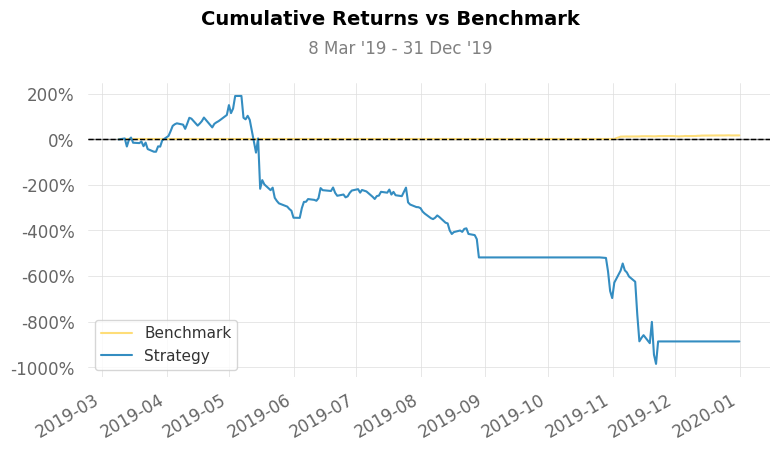

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


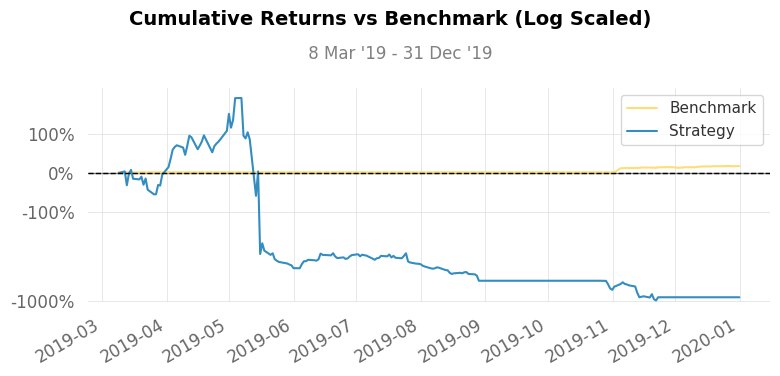

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


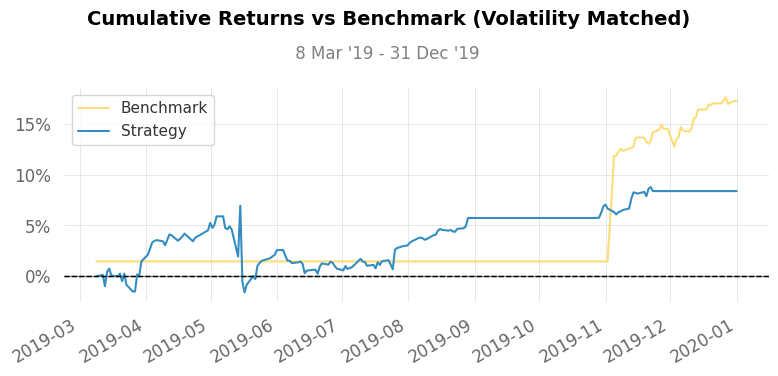

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


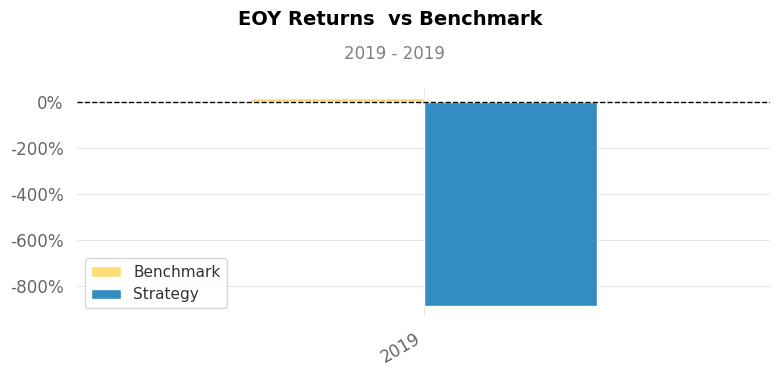

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


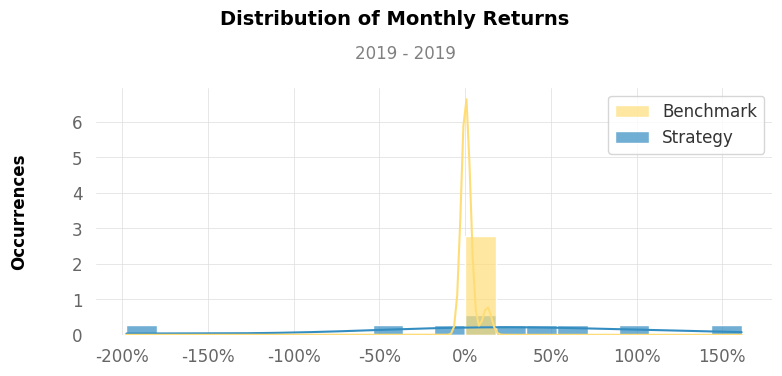

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


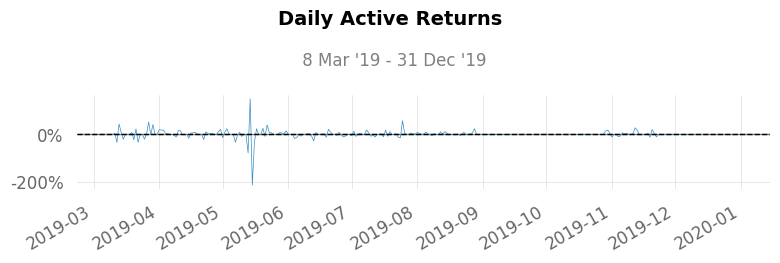

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


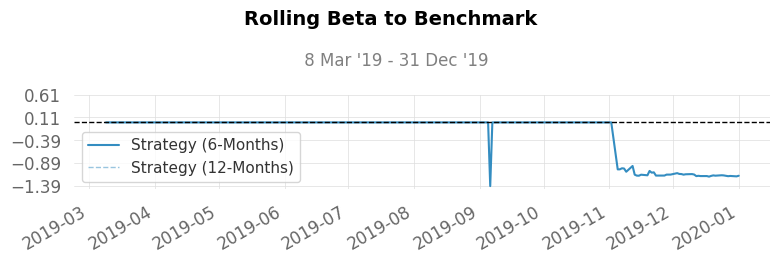

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


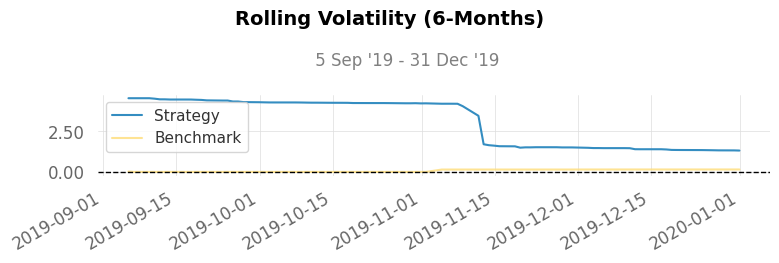

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


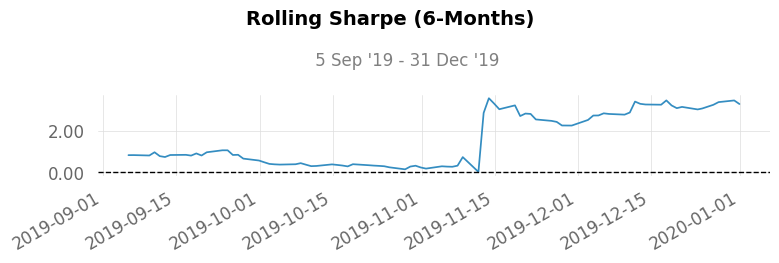

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


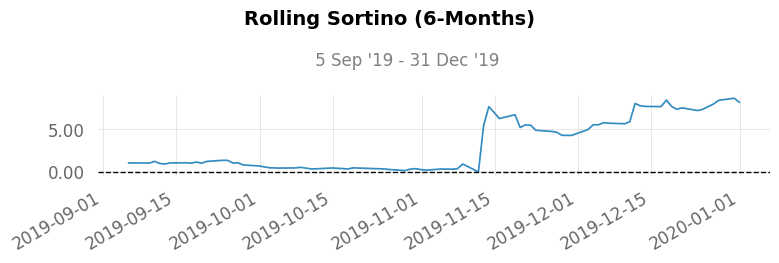

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


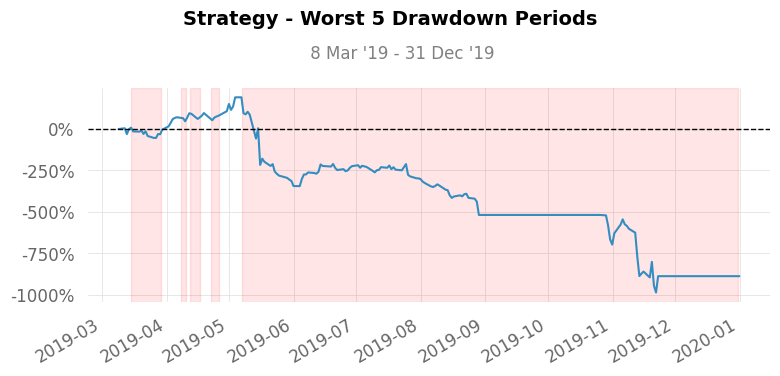

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


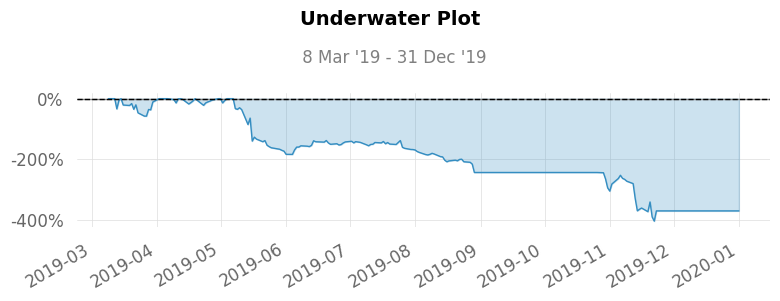

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


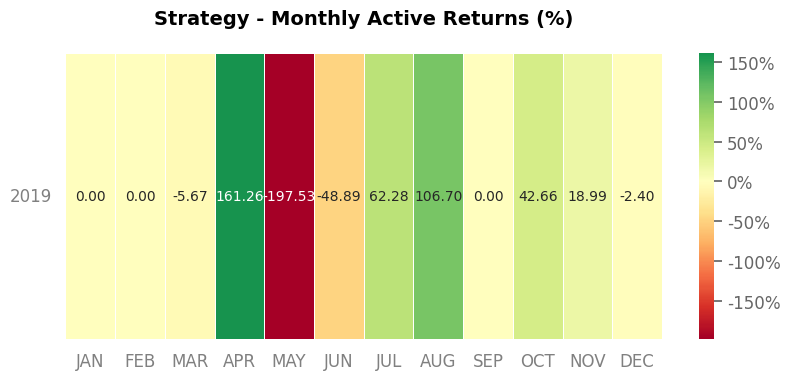

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


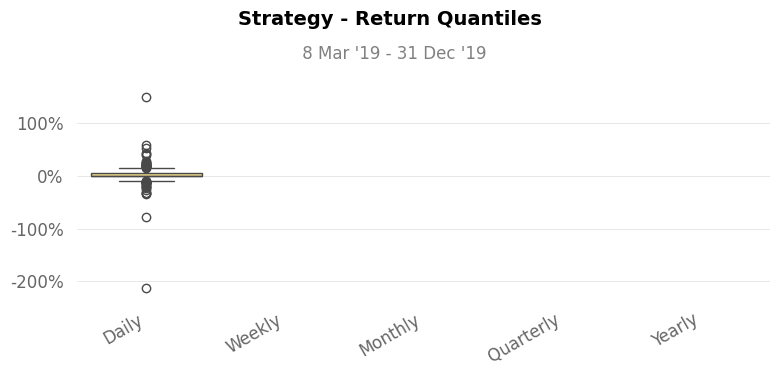

In [ ]:
qs.reports.full(result_rsi_bollinger.returns,benchmark=spy_return_series)